# Detailed analysis of results.

This notebook loads the output of the scripts in the directory ``cluster_scripts`` (particularly, the final script,  ``run_slurm_pred_error.py``).   It produces the Rdata file that is used for the graphs in the paper as well as a number of supplemental analyses.

In [1]:
library(tidyverse)
library(gridExtra)
library(repr) # For setting plot sizes
source("load_python_data_lib.R")
py_main <- InitializePython()

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.8
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine


Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths



In [14]:
# Choose the initialization method.
init_method <- "kmeans" # This is the choice for the paper.
#init_method <- "warm"

# Choose whether or not to re-run the regressions before calculating test error.
use_rereg <- FALSE # This is the choice for the paper.
#use_rereg <- TRUE

# This is the file that is used in the paper's knitr.
save_dir <- "../../fits"
save_filename <- sprintf("paper_results_init_%s_rereg_%s.Rdata", init_method, use_rereg)

### Load the saved data for all dfs and k



In [3]:
dfs <- list()
metadata_dfs <- list()

for (lo_num_times in 1:3) {
  cat("lo_num_times ", lo_num_times) 
  for (df in 4:8) {
    cat(".")
    load_res <- LoadPredictionError(df, lo_num_times, init_method)
    this_refit_err_df <- load_res$refit_err_df
    this_metadata_df <- load_res$metadata_df
    this_refit_err_melt <- MeltErrorColumns(this_refit_err_df)
    dfs[[length(dfs) + 1]] <- this_refit_err_melt
    metadata_dfs[[length(metadata_dfs) + 1]] <- this_metadata_df
  }
  cat("\n")
}
cat("Done.\n")
refit_err_melt <- do.call(bind_rows, dfs)
metadata_df <- do.call(bind_rows, metadata_dfs)

lo_num_times  1.....
lo_num_times  2.....
lo_num_times  3.....
Done.


### Metadata (timing, parameter dimensions)

Make a tidy dataframe with the metadata.  The parameter length, Hessian time, and initial optimization time are all reported in the text of the paper.  Their values will be derived from this dataframe in knitr.

In [4]:
metadata_df <-
    metadata_df %>%
    mutate(lr_hess_time=total_lr_time + initial_hess_time,
           avg_lr_time=total_lr_time / num_comb,
           avg_refit_time=total_refit_time / num_comb,
           param_length=gmm_param_length + reg_param_length)
print(names(metadata_df))

select(metadata_df, df, param_length) %>%
    group_by(df) %>%
    summarize(param_length=unique(param_length))

select(metadata_df, df, initial_hess_time, initial_opt_time) %>%
    group_by(df) %>%
    summarize(initial_hess_time=median(initial_hess_time),
              initial_opt_time=median(initial_opt_time))

round(median(metadata_df$initial_opt_time), digits=-1)

 [1] "num_comb"          "total_lr_time"     "total_refit_time" 
 [4] "initial_opt_time"  "initial_reg_time"  "initial_hess_time"
 [7] "gmm_param_length"  "reg_param_length"  "df"               
[10] "lo_num_times"      "init_method"       "lr_hess_time"     
[13] "avg_lr_time"       "avg_refit_time"    "param_length"     


df,param_length
4,25325
5,31643
6,38661
7,46379
8,54797


df,initial_hess_time,initial_opt_time
4,275.7295,31.44656
5,295.0325,41.84182
6,359.6855,35.11145
7,478.7345,50.88843
8,584.4987,77.02919


[1] 40

Make a dataframe for the timing plot from the metadata.

In [5]:
metadata_graph_df <-
    metadata_df %>%
    select(df, lo_num_times, total_refit_time, lr_hess_time, initial_opt_time) %>%
    melt(id.vars=c("lo_num_times", "df"))
head(metadata_graph_df)

lo_num_times,df,variable,value
1,4,total_refit_time,338.1638
1,5,total_refit_time,391.6006
1,6,total_refit_time,423.8322
1,7,total_refit_time,632.2635
1,8,total_refit_time,599.0894
2,4,total_refit_time,1123.7316


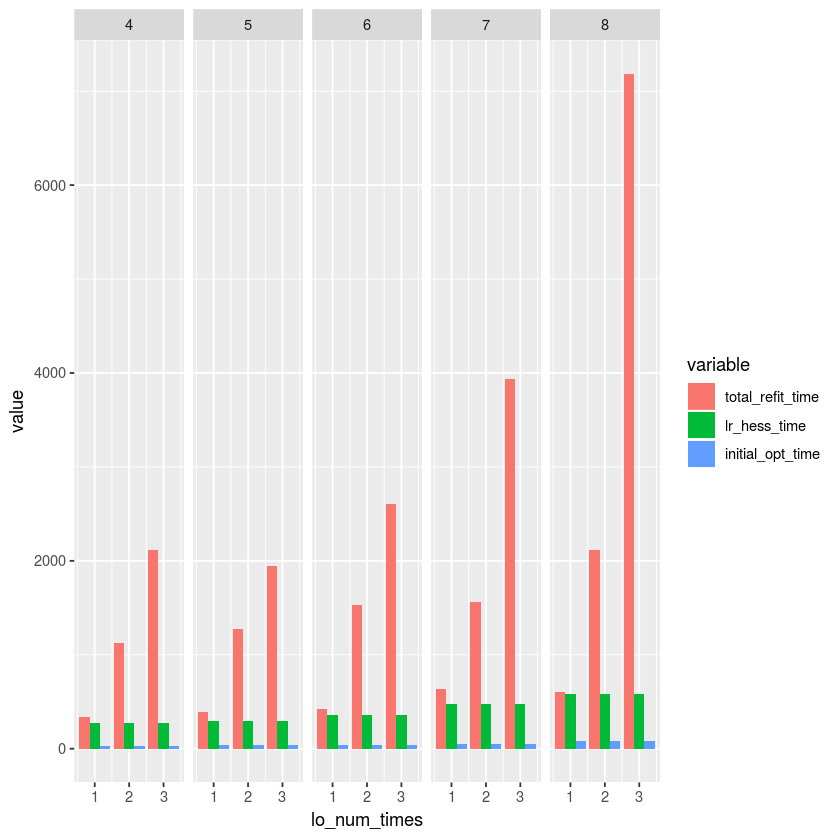

In [6]:
ggplot(metadata_graph_df) +
    geom_bar(aes(x=lo_num_times, y=value, fill=variable, group=variable),
             stat="identity", position=position_dodge()) +
    facet_grid( ~ df)

### Calculate prediction errors

Make summaries of prediction error for various methods and datasets.

In [7]:
# In-sample IJ error.
lr_df <-
  refit_err_melt %>%
  filter(rereg==use_rereg, method=="lin", test==FALSE, measure=="err") %>%
  rename(error=value) %>%
  mutate(output="lin_in_sample")

# In-sample CV error.
cv_df <-
  refit_err_melt %>%
  filter(rereg==use_rereg, method=="ref", test==FALSE, measure=="err") %>%
  rename(error=value) %>%
  mutate(output="cv_in_sample")

# In-sample training error (no points left out).
train_df <-
  refit_err_melt %>%
  filter(rereg==use_rereg, method=="ref", test==FALSE, measure=="train_err") %>%
  rename(error=value) %>%
  mutate(output="train_error")

# Out-of-sample test error.
test_df <-
  refit_err_melt %>%
  filter(rereg==use_rereg, method=="ref", test==TRUE, measure=="train_err") %>%
  rename(error=value) %>%
  mutate(output="test_error")

refit_for_df_choice <- bind_rows(
  lr_df, cv_df, test_df, train_df)

In [8]:
head(refit_for_df_choice)

test,method,comb,rereg,gene,df,lo_num_times,time,measure,error,output
FALSE,lin,0,FALSE,0,4,1,0,err,1.0088933,lin_in_sample
FALSE,lin,0,FALSE,1,4,1,0,err,0.1243607,lin_in_sample
FALSE,lin,0,FALSE,2,4,1,0,err,-0.4340983,lin_in_sample
FALSE,lin,0,FALSE,3,4,1,0,err,-0.2203431,lin_in_sample
FALSE,lin,0,FALSE,4,4,1,0,err,1.9032786,lin_in_sample
FALSE,lin,0,FALSE,5,4,1,0,err,-0.2876837,lin_in_sample


Make a tidy dataframe for choosing ``df``.  The graph in the paper will be based on this dataframe.

Note that most of the signal for choosing ``df`` is already in the training data error.  However, there is an uptick in error in both CV and IJ for ``df=8`` which is not captured by the training data error.

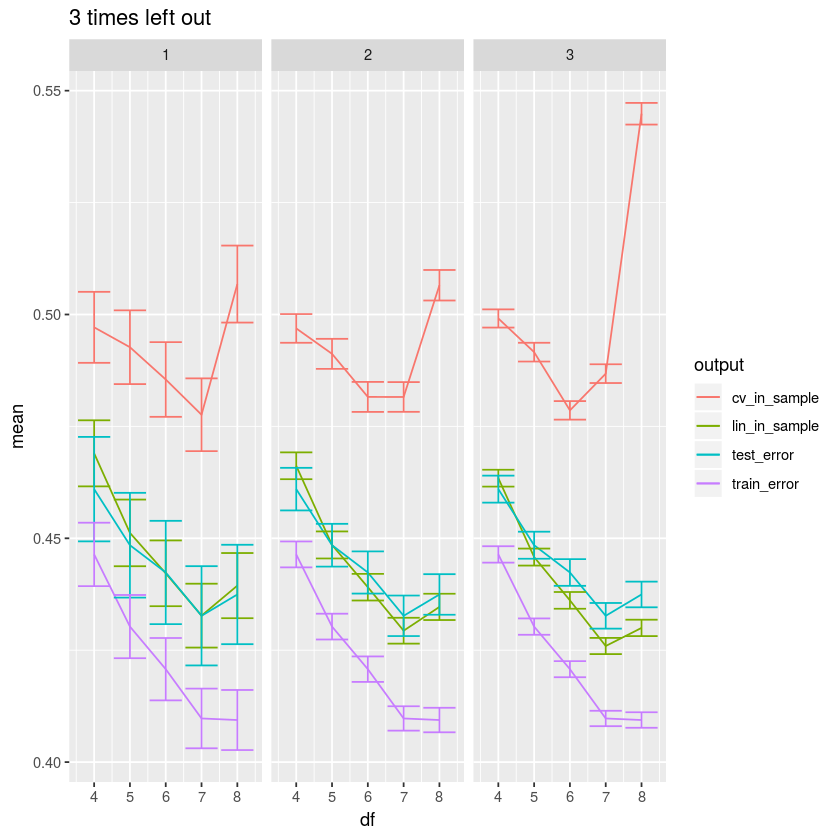

In [16]:
refit_err_summary <-
  refit_for_df_choice %>%
  group_by(output, df, lo_num_times) %>%
  mutate(esize=abs(error)) %>%
  summarize(med=median(esize),
            mean=mean(esize),
            n_obs=n(),
            se=sd(esize) / sqrt(n_obs),
            qlow=quantile(esize, 0.25),
            qhigh=quantile(esize, 0.75))

ggplot(refit_err_summary) +
  geom_line(aes(x=df, y=mean, group=output, color=output)) +
  geom_errorbar(aes(x=df, ymin=mean - 2 * se, ymax=mean + 2 * se,
                    group=output, color=output)) +
  facet_grid(~ lo_num_times) +
  ggtitle(sprintf("%d times left out", lo_num_times))

### Gene-by-gene accuracy measures.

In [17]:
refit_err_plot <-
  refit_err_melt %>%
  filter(rereg==use_rereg) %>%
  dcast(df + lo_num_times + test + comb + rereg + gene + time ~ method + measure,
        value.var=c("value"))

We now look at the correlation between the CV and IJ prediction errors across genes.  For each ``df`` and ``k``, there are a number of different combinations of left-out points.  We report the median, min, and max correlation coefficients across these combinations of left-out points.

First, we show the correlation between the raw prediction errors.  Although the correlation is quite high, this is because the training error at the original optimum is the principle source of variation in the errors across genes, and this quantity is common to both CV and IJ.

In [19]:
err_corr <- refit_err_plot %>%
  filter(test==FALSE, rereg==use_rereg) %>%
  group_by(df, lo_num_times, comb) %>%
  summarize(r=cor(lin_err, ref_err)) %>%
  group_by(df, lo_num_times) %>%
  summarize(med_r=median(r), min_r=min(r), max_r=max(r))

print("Correlation between error: ")
print(err_corr)

[1] "Correlation between error: "
# A tibble: 15 x 5
# Groups:   df [?]
      df lo_num_times med_r min_r max_r
   <int>        <int> <dbl> <dbl> <dbl>
 1     4            1 0.974 0.949 0.984
 2     4            2 0.975 0.902 0.992
 3     4            3 0.967 0.871 0.991
 4     5            1 0.963 0.856 0.983
 5     5            2 0.966 0.860 0.984
 6     5            3 0.947 0.759 0.981
 7     6            1 0.980 0.807 0.985
 8     6            2 0.968 0.835 0.986
 9     6            3 0.929 0.759 0.983
10     7            1 0.962 0.794 0.974
11     7            2 0.952 0.737 0.976
12     7            3 0.914 0.599 0.974
13     8            1 0.962 0.703 0.971
14     8            2 0.941 0.663 0.974
15     8            3 0.829 0.251 0.958


A more meaningful measure is the correlation in the excess error for IJ and CV over the error at the original fit.

In [23]:
diff_corr <- refit_err_plot %>%
  filter(test==FALSE, rereg==use_rereg) %>%
  group_by(df, lo_num_times, comb) %>%
  summarize(r=cor(lin_e_diff, ref_e_diff)) %>%
  group_by(df, lo_num_times) %>%
  summarize(med_r=median(r), min_r=min(r), max_r=max(r))

print("Correlation between difference from train error: ")
print(diff_corr)


[1] "Correlation between difference from train error: "
# A tibble: 15 x 5
# Groups:   df [?]
      df lo_num_times med_r   min_r max_r
   <int>        <int> <dbl>   <dbl> <dbl>
 1     4            1 0.483  0.0956 0.844
 2     4            2 0.577  0.277  0.828
 3     4            3 0.605  0.303  0.833
 4     5            1 0.464  0.143  0.728
 5     5            2 0.510  0.330  0.709
 6     5            3 0.510  0.312  0.671
 7     6            1 0.655  0.368  0.783
 8     6            2 0.588  0.218  0.845
 9     6            3 0.499  0.0701 0.737
10     7            1 0.660  0.512  0.760
11     7            2 0.564  0.224  0.863
12     7            3 0.491  0.0344 0.801
13     8            1 0.744  0.380  0.900
14     8            2 0.646  0.166  0.862
15     8            3 0.214 -0.226  0.767


For higher degrees of freedom, increasing the number of left-out points seems to decrease the IJ's accuracy, as you might expect.

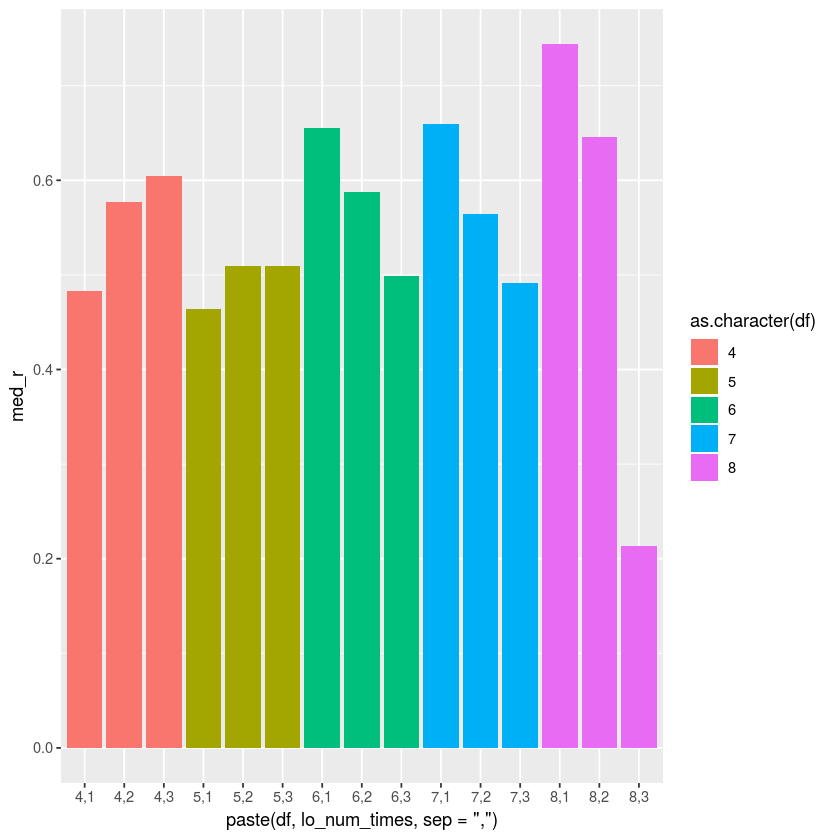

In [29]:
ggplot(diff_corr) + 
    geom_bar(aes(x=paste(df, lo_num_times, sep=","),
                 y=med_r, fill=as.character(df)), stat="identity")

Plot the densities of the IJ and CV with points to show outliers. This is a graphical version of the results summarized by the correlation tables above.

Warning message:
“Removed 10770 rows containing non-finite values (stat_density2d).”Warning message:
“Removed 10770 rows containing missing values (geom_point).”

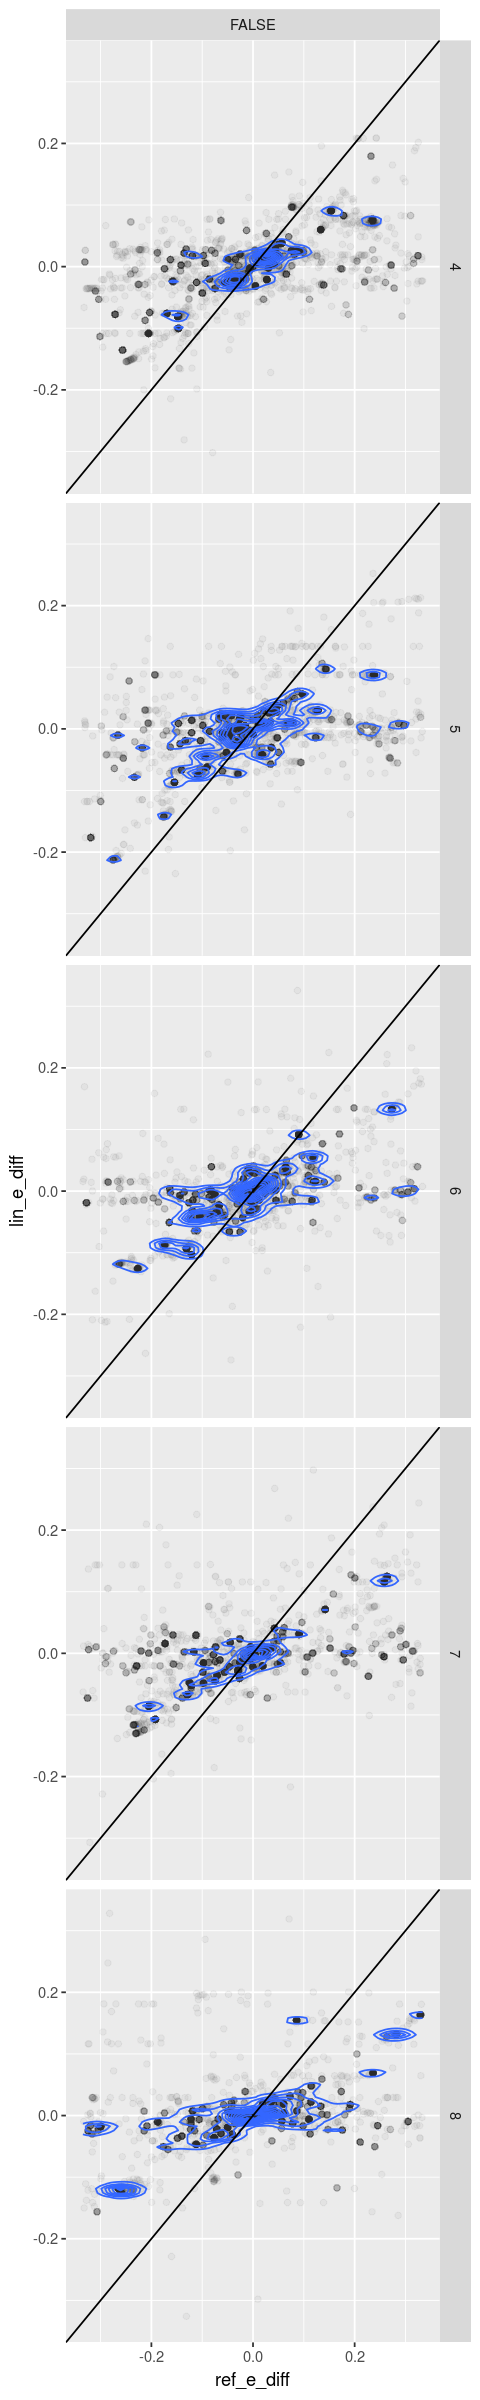

In [34]:
# There are a few outliers, so limit the extent of the plot so that
# the bulk of the distribution is visible.
qlim <- quantile(refit_err_plot$ref_e_diff, c(0.1, 0.9))

options(repr.plot.width=4, repr.plot.height=20)

# This plot, or ones like it, is probably the best measure of
# the accuracy of the IJ.
ggplot(filter(refit_err_plot, test == FALSE, lo_num_times==1)) +
    geom_point(aes(x=ref_e_diff, y=lin_e_diff), alpha=0.01) +
    geom_density2d(aes(x=ref_e_diff, y=lin_e_diff)) +
    geom_abline(aes(slope=1, intercept=0)) +
    facet_grid(df ~ rereg) +
    xlim(qlim[1], qlim[2]) + ylim(qlim[1], qlim[2])


### Save results for plotting in the paper.

In [35]:
print(sprintf("Saving to %s", file.path(save_dir, save_filename)))
save(refit_err_summary,
     metadata_df,
     diff_corr,
     err_corr,
     file=file.path(save_dir, save_filename))

[1] "Saving to ../../fits/paper_results_init_kmeans_rereg_FALSE.Rdata"
